In [142]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error

seed = 7
tf.random.set_seed(seed)

In [143]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [144]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [149]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}, x_test=None, y_test=None ):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
        
    return model

In [150]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [151]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 5/5 [01:25<00:00, 17.14s/it]


Median val_loss: 0.00047501391964033246, std val_loss 0.0012387443125981583
Median train_loss: 0.00039174515404738486, std train_loss 0.00011182861542526954
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 1.0, train_accuracy 0.0






Best configuration (loss 0.00047501391964033246):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:17<02:33, 17.10s/it]

Trial 1/10 val_mse: 0.00018074229592457414
Trial 1/10 train_mse: 0.00011751984857255593
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:32<02:07, 15.93s/it]

Trial 2/10 val_mse: 0.0003046539204660803
Trial 2/10 train_mse: 0.00014938546519260854
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:48<01:51, 15.98s/it]

Trial 3/10 val_mse: 0.00047968802391551435
Trial 3/10 train_mse: 0.000163889373652637
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [01:02<01:30, 15.17s/it]

Trial 4/10 val_mse: 0.0012153801508247852
Trial 4/10 train_mse: 0.000251091638347134
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [01:17<01:15, 15.09s/it]

Trial 5/10 val_mse: 0.0008660850580781698
Trial 5/10 train_mse: 0.00024386888253502548
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [01:37<01:07, 16.81s/it]

Trial 6/10 val_mse: 0.00044666859321296215
Trial 6/10 train_mse: 0.0002444752608425915
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:55<00:51, 17.21s/it]

Trial 7/10 val_mse: 0.0022130729630589485
Trial 7/10 train_mse: 0.00033941955189220607
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [02:09<00:32, 16.12s/it]

Trial 8/10 val_mse: 0.0005008243606425822
Trial 8/10 train_mse: 0.00019561203953344375
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [02:16<00:13, 13.51s/it]

Trial 9/10 val_mse: 0.006109452340751886
Trial 9/10 train_mse: 0.0010557055938988924
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [02:32<00:00, 15.28s/it]

Trial 10/10 val_mse: 0.003390825353562832
Trial 10/10 train_mse: 0.0002687291707843542
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.0008660850580781698, std val_mse: 0.001791137885448676
Median train_mse: 0.00024386888253502548, std train_mse: 0.0002583731680804905
Median val_accuracy: 1.0, std val_accuracy: 0.0
Median train_accuracy: 1.0, std train_accuracy: 0.0


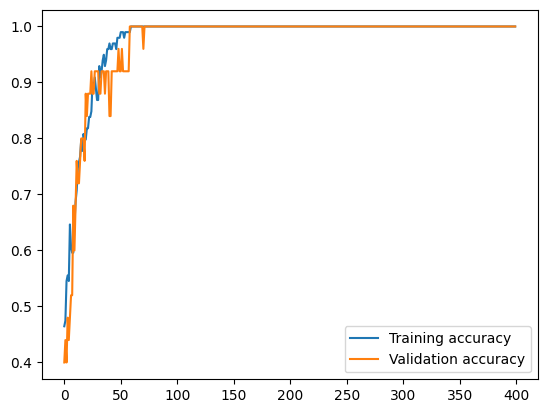

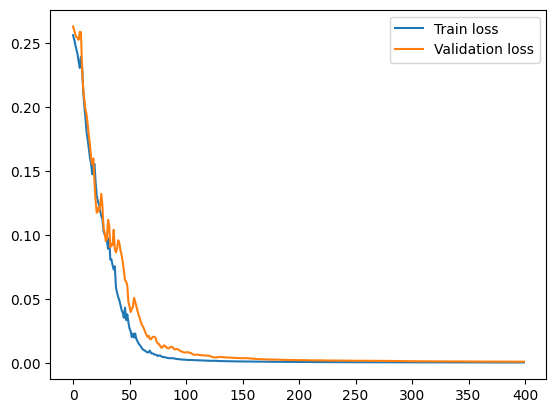

14/14 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
[0.001103222370147705, 1.0]


In [152]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

# Monks 2

In [133]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [168]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.8],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 5/5 [00:37<00:00,  7.44s/it]


Median val_loss: 0.12362547963857651, std val_loss 0.09322665755462804
Median train_loss: 0.046446267515420914, std train_loss 0.05439393101243089
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.1306281419735712
Median train_accuracy: 0.961904764175415, train_accuracy 0.0565043660575679






Best configuration (loss 0.12362547963857651):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:12<01:49, 12.15s/it]

Trial 1/10 val_mse: 0.001442444627173245
Trial 1/10 train_mse: 0.000543556350748986
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:25<01:40, 12.57s/it]

Trial 2/10 val_mse: 0.0014755451120436192
Trial 2/10 train_mse: 0.001567514380440116
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:33<01:14, 10.65s/it]

Trial 3/10 val_mse: 0.00901222974061966
Trial 3/10 train_mse: 0.0037883531767874956
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:49<01:17, 12.83s/it]

Trial 4/10 val_mse: 0.0012586726807057858
Trial 4/10 train_mse: 0.0004315180703997612
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:51<00:45,  9.04s/it]

Trial 5/10 val_mse: 0.11349032074213028
Trial 5/10 train_mse: 0.08981156349182129
Trial 5/10 val_accuracy: 0.8799999952316284
Trial 5/10 train_accuracy: 0.8888888955116272


 60%|██████████████████████████▍                 | 6/10 [01:04<00:41, 10.33s/it]

Trial 6/10 val_mse: 0.0014093626523390412
Trial 6/10 train_mse: 0.0006616192404180765
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:07<00:23,  7.82s/it]

Trial 7/10 val_mse: 0.15179158747196198
Trial 7/10 train_mse: 0.0809621587395668
Trial 7/10 val_accuracy: 0.7599999904632568
Trial 7/10 train_accuracy: 0.8989899158477783


 80%|███████████████████████████████████▏        | 8/10 [01:20<00:18,  9.43s/it]

Trial 8/10 val_mse: 0.002023333217948675
Trial 8/10 train_mse: 0.001381042180582881
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:32<00:10, 10.46s/it]

Trial 9/10 val_mse: 0.0015517751453444362
Trial 9/10 train_mse: 0.0006608276744373143
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:46<00:00, 10.69s/it]

Trial 10/10 val_mse: 0.0008841349044814706
Trial 10/10 train_mse: 0.001063479227013886
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.0015517751453444362, std val_mse: 0.05285090485027441
Median train_mse: 0.0006608276744373143, std train_mse: 0.03372052256476945
Median val_accuracy: 1.0, std val_accuracy: 0.07683749390244175
Median train_accuracy: 1.0, std train_accuracy: 0.04248432037120888


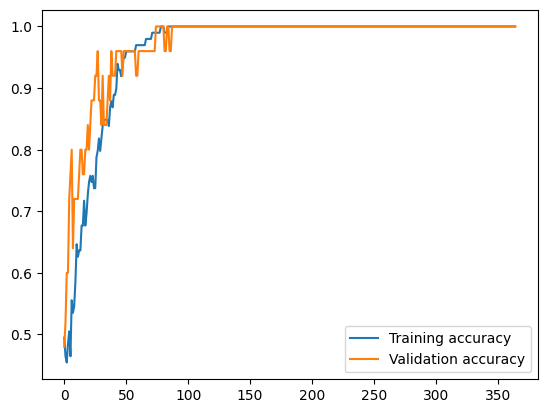

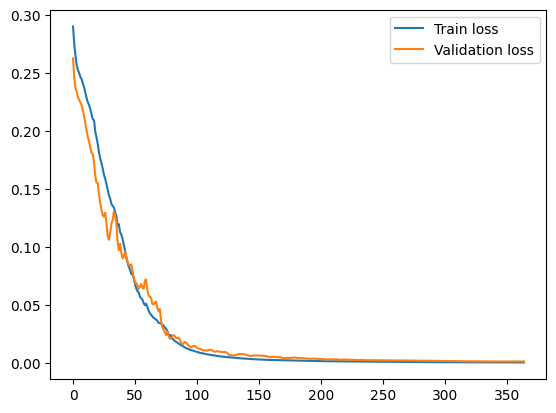

14/14 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
[0.0016602040268480778, 1.0]


In [156]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

# Monks 3

In [180]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.05],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None,
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}



k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [181]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.05, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.66s/it]


Median val_loss: 0.0726756826043129, std val_loss 0.0043971222593657535
Median train_loss: 0.04860129952430725, std train_loss 0.002405324828151145
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0038835048675537106






Best configuration (loss 0.0726756826043129):
{'batch_size': None, 'learning_rate': 0.05, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:02<00:21,  2.40s/it]

Trial 1/10 val_mse: 0.044589072465896606
Trial 1/10 train_mse: 0.052333589643239975
Trial 1/10 val_accuracy: 0.9599999785423279
Trial 1/10 train_accuracy: 0.9278350472450256


 20%|████████▊                                   | 2/10 [00:04<00:18,  2.29s/it]

Trial 2/10 val_mse: 0.05559542030096054
Trial 2/10 train_mse: 0.06044131517410278
Trial 2/10 val_accuracy: 0.9599999785423279
Trial 2/10 train_accuracy: 0.9278350472450256


 30%|█████████████▏                              | 3/10 [00:08<00:21,  3.05s/it]

Trial 3/10 val_mse: 0.053845569491386414
Trial 3/10 train_mse: 0.04679998755455017
Trial 3/10 val_accuracy: 0.9599999785423279
Trial 3/10 train_accuracy: 0.938144326210022


 40%|█████████████████▌                          | 4/10 [00:13<00:21,  3.63s/it]

Trial 4/10 val_mse: 0.06828930974006653
Trial 4/10 train_mse: 0.051952265202999115
Trial 4/10 val_accuracy: 0.9200000166893005
Trial 4/10 train_accuracy: 0.969072163105011


 50%|██████████████████████                      | 5/10 [00:16<00:17,  3.46s/it]

Trial 5/10 val_mse: 0.05001949891448021
Trial 5/10 train_mse: 0.054437559098005295
Trial 5/10 val_accuracy: 0.9599999785423279
Trial 5/10 train_accuracy: 0.938144326210022


 60%|██████████████████████████▍                 | 6/10 [00:18<00:12,  3.20s/it]

Trial 6/10 val_mse: 0.061481133103370667
Trial 6/10 train_mse: 0.05418814346194267
Trial 6/10 val_accuracy: 0.9200000166893005
Trial 6/10 train_accuracy: 0.938144326210022


 70%|██████████████████████████████▊             | 7/10 [00:21<00:08,  3.00s/it]

Trial 7/10 val_mse: 0.06737364828586578
Trial 7/10 train_mse: 0.04070410504937172
Trial 7/10 val_accuracy: 0.9200000166893005
Trial 7/10 train_accuracy: 0.9484536051750183


 80%|███████████████████████████████████▏        | 8/10 [00:24<00:05,  2.86s/it]

Trial 8/10 val_mse: 0.049905166029930115
Trial 8/10 train_mse: 0.05517273768782616
Trial 8/10 val_accuracy: 0.9599999785423279
Trial 8/10 train_accuracy: 0.938144326210022


 90%|███████████████████████████████████████▌    | 9/10 [00:26<00:02,  2.73s/it]

Trial 9/10 val_mse: 0.04810347035527229
Trial 9/10 train_mse: 0.04742538183927536
Trial 9/10 val_accuracy: 0.9599999785423279
Trial 9/10 train_accuracy: 0.938144326210022


100%|███████████████████████████████████████████| 10/10 [00:29<00:00,  2.95s/it]

Trial 10/10 val_mse: 0.059991054236888885
Trial 10/10 train_mse: 0.047965239733457565
Trial 10/10 val_accuracy: 0.9599999785423279
Trial 10/10 train_accuracy: 0.9278350472450256

Median val_mse: 0.05559542030096054, std val_mse: 0.007723835648156184
Median train_mse: 0.06044131517410278, std train_mse: 0.005259733869328248
Median val_accuracy: 0.9599999785423279, std val_accuracy: 0.018330285298684388
Median train_accuracy: 0.9278350472450256, std train_accuracy: 0.011709090070700182


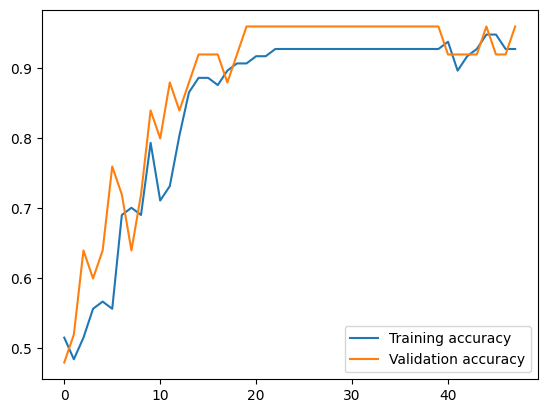

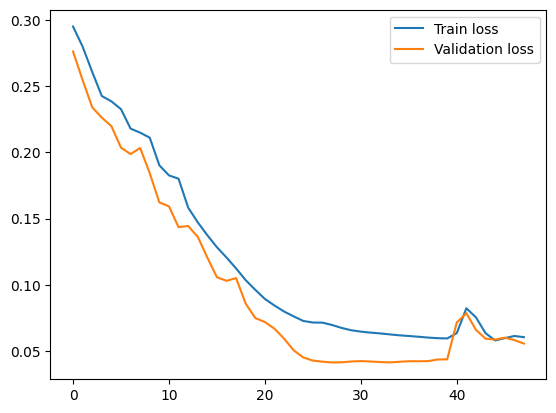

14/14 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9722
[0.036842960864305496, 0.9722222089767456]


In [182]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

# ML Cup

In [37]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#print(x_test_blind.shape)

(1343, 9) (1343, 2)
(149, 9) (149, 2)


In [52]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 5,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "nesterov": False,
    "momentum": [0.9],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.0001
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.001]
        }
    ],
    "layers": [
        {
            "activations": ["relu", "tanh"],
            "units": [10],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/2:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.0001}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 10}


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.49s/it]


Median val_loss: 0.09274468570947647, std val_loss 0.0003561469626906692
Median train_loss: 0.10606355965137482, std train_loss 0.00033851843584403534
Median val_mee: 0.3097965121269226, std val_mee 0.004422221416718771
Median train_mee: 0.3271438777446747, train_mee 0.003636060084772021



Testing configuration 2/2:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.0001}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'tanh', 'units_1': 10}


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.84s/it]


Median val_loss: 0.1418958604335785, std val_loss 0.0026807436315948517
Median train_loss: 0.09811078757047653, std train_loss 0.003089252120680748
Median val_mee: 0.35076552629470825, std val_mee 0.006192688254093582
Median train_mee: 0.30133238434791565, train_mee 0.007391674616275098






Best configuration (loss 0.09274468570947647):
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.0001}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 10}


 20%|█████████                                    | 1/5 [00:42<02:49, 42.38s/it]

Trial 1/5 test_loss: 0.1147083193063736
Trial 1/5 train_loss: 0.10150168836116791
Trial 1/5 test_mee: 0.3496996760368347
Trial 1/5 train_mee: 0.3266049921512604


 40%|██████████████████                           | 2/5 [01:26<02:09, 43.15s/it]

Trial 2/5 test_loss: 0.11412600427865982
Trial 2/5 train_loss: 0.10208669304847717
Trial 2/5 test_mee: 0.3460191786289215
Trial 2/5 train_mee: 0.32360950112342834


 60%|███████████████████████████                  | 3/5 [02:11<01:28, 44.02s/it]

Trial 3/5 test_loss: 0.11420928686857224
Trial 3/5 train_loss: 0.10200551897287369
Trial 3/5 test_mee: 0.3463076949119568
Trial 3/5 train_mee: 0.324096143245697


 80%|████████████████████████████████████         | 4/5 [02:55<00:44, 44.10s/it]

Trial 4/5 test_loss: 0.11248280107975006
Trial 4/5 train_loss: 0.10432696342468262
Trial 4/5 test_mee: 0.33705371618270874
Trial 4/5 train_mee: 0.323336124420166


100%|█████████████████████████████████████████████| 5/5 [03:36<00:00, 43.27s/it]

Trial 5/5 test_loss: 0.11351817101240158
Trial 5/5 train_loss: 0.10339853912591934
Trial 5/5 test_mee: 0.3412395119667053
Trial 5/5 train_mee: 0.322288453578949

Median test_loss: 0.11412600427865982, std test_loss 0.0007632668662928192
Median train_loss: 0.10208669304847717, std train_loss 0.0010414263231901875
Median test_mee: 0.3460191786289215, std test_mee 0.004421301766683761
Median train_mee: 0.32360950112342834, std train_mee 0.001436453933103378


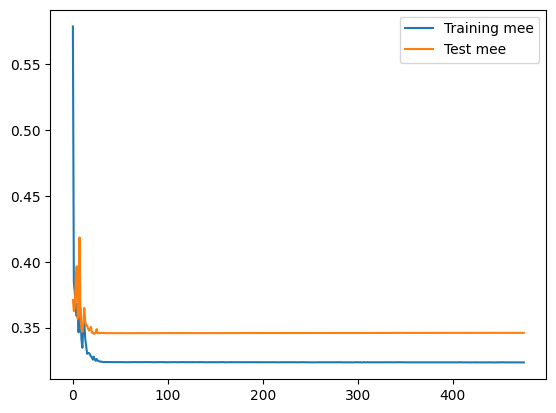

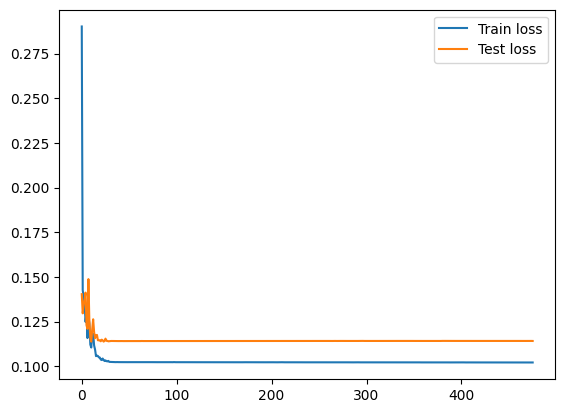

5/5 [==============================] - 0s 2ms/step
Train MSE: 3.9112211152592953
Train MEE: 1.6081613090008149
Test MSE: 4.460952486426812
Test MEE: 1.7057973561205015


In [53]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
assess_model(model, x_train, y_train, x_test, y_test, True)

42/42 [==============================] - 0s 1ms/step


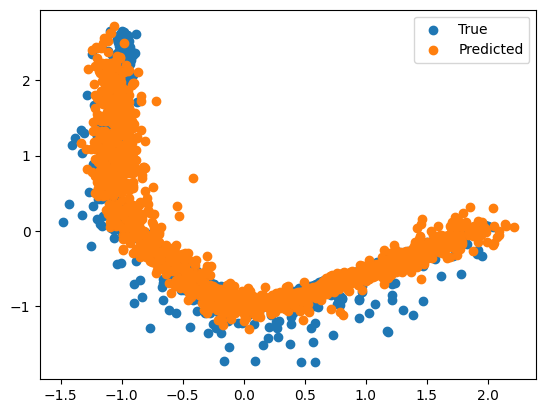

In [66]:
# y_train_rescaled = scaler.inverse_transform(y_train)
# print(y_train.shape)

plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
pred = model.predict(x_train)
# pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()